## Suppl. Fig. 6 panel H Compare pairwise protein distance in PCA space between OrgIP and Cytoself

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys, os
import tqdm.notebook as tqdm
from sklearn.decomposition import PCA

data_path = Path.cwd().parent.parent.parent.parent / "data"
script_path = Path.cwd().parent.parent.parent.parent / "script"
sys.path.append(str(script_path))

from utils.distance import calc_all_dist_mat, extract_pairwise_distances

# output dir
output_dir = Path.cwd() / "output"
output_dir.mkdir(exist_ok=True)

In [2]:
# distance parameters
metric = "cosine" # distance metric, possible values are ["euclidean", "canberra", "correlation", "cosine", "minkowski"]

# grid scan for best PCA n_components
grid_scan = False # set False to skip the grid scan
OrgIP_scan_list = [2, 5, 10, 15, 20, 30, 40, 50]
cytoself_scan_list = [2, 5, 10, 20, 50, 100, 200, 500, 1000] 

# PCA parameters
cytoself_ncomp = 1000 # number of PCA components to use for computing pairwise distance in image space (cytoself), derived from the grid scan
OrgIP_ncomp = 30 # number of components to use for computing pairwise distance in organelle IP enrichment space, derived from the grid scan

In [3]:
# %store -r timestamp
# print(f"Timestamp: {timestamp}")
timestamp = "2023-10-21-imp5-for-figures"

### load data

In [4]:
# load cytoself distances
cytoself_part1 = pd.read_csv(data_path / 'external' / 'cytoself_gene_df_with_embvec_part1.csv', index_col=0)
cytoself_part2 = pd.read_csv(data_path / 'external' / 'cytoself_gene_df_with_embvec_part2.csv', index_col=0)
cytoself = pd.concat([cytoself_part1, cytoself_part2], axis=0)
cytoself.shape

(1311, 9216)

In [5]:
# load data to compute OrgIP distances
data_path = Path.cwd().parent.parent.parent / "Fig2" / "panel_B" / "output" / f"{timestamp}_scaled_data.csv"
OrgIP_data = pd.read_csv(data_path, index_col=0)
OrgIP_data.shape

(8541, 61)

### get the intersect of proteins between OrgIP and Cytoself

In [6]:
OrgIP_proteins = OrgIP_data.index
cytoself_proteins = cytoself.index

intersection = list(set(np.intersect1d(OrgIP_proteins, cytoself_proteins)))
print(f"Number of proteins in common: {len(intersection)}")

Number of proteins in common: 1251


In [7]:
# subset the data
cytoself = cytoself.loc[intersection]
OrgIP_data = OrgIP_data.loc[intersection]

### grid scan for best PCA components

In [8]:
# Initialize a 2D array to hold the metric results
grid_scan_results = np.zeros((len(OrgIP_scan_list), len(cytoself_scan_list)))  
grid_scan_results = pd.DataFrame(grid_scan_results, index=OrgIP_scan_list, columns=cytoself_scan_list)

if grid_scan:
    for n_orgIP in tqdm.tqdm(OrgIP_scan_list):
        for n_cytoself in tqdm.tqdm(cytoself_scan_list, leave=False):

            _cytoself = cytoself.copy()
            _OrgIP_data = OrgIP_data.copy()

            pca = PCA(n_components=n_cytoself)
            pca.fit(_cytoself)
            cytoself_pca = pca.transform(_cytoself)

            pca = PCA(n_components=n_orgIP)
            pca.fit(_OrgIP_data)
            OrgIP_pca = pca.transform(_OrgIP_data)

            _cytoself = pd.DataFrame(cytoself_pca, index=_cytoself.index)
            _OrgIP_data = pd.DataFrame(OrgIP_pca, index=_OrgIP_data.index)

            OrgIP_distMats = calc_all_dist_mat(data=_OrgIP_data)
            cytoself_distMats = calc_all_dist_mat(data=_cytoself)

            orgIP_pairwise_dist = extract_pairwise_distances(OrgIP_distMats[metric], _OrgIP_data.index)
            cytoself_pairwise_dist = extract_pairwise_distances(cytoself_distMats[metric], _cytoself.index)

            # sanity check
            assert len(orgIP_pairwise_dist) == len(cytoself_pairwise_dist)
            for pair in orgIP_pairwise_dist:
                assert pair in cytoself_pairwise_dist
            for pair in cytoself_pairwise_dist:
                assert pair in orgIP_pairwise_dist

                # compile the distances into a single dataframe
            list_of_rows = []
            for pair in orgIP_pairwise_dist:
                new_row = {'protein pair': pair, 'cytoself': cytoself_pairwise_dist[pair], 'OrgIP': orgIP_pairwise_dist[pair]}
                list_of_rows.append(new_row)
            df = pd.DataFrame(list_of_rows)

            # compute pearson correlation
            p_corr = df.iloc[:,1:3].corr( method='pearson').iloc[0,1]

            grid_scan_results.loc[n_orgIP, n_cytoself] = p_corr

In [9]:
# plot scan resuluts
if grid_scan:
    # Set the figure size for better readability
    plt.figure(figsize=(12, 8))

    # Create the heatmap using seaborn
    heatmap = sns.heatmap(
        grid_scan_results,
        annot=True,          # Annotate cells with the correlation coefficient
        fmt=".2f",           # Format the annotations to two decimal places
        cmap='viridis',      # Choose a colormap
        cbar_kws={'label': 'Pearson Correlation Coefficient'},  # Label for the color bar
    )

    # Set the labels and title
    plt.title('Heatmap of Pearson Correlation over PCA Component Grid')
    plt.xlabel('Number of Cytoself PCA Components')
    plt.ylabel('Number of OrgIP PCA Components')

    # Adjust the axis tick labels for better readability
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)

    # Display the plot
    plt.tight_layout()
    plt.show()


### compute PCA 

In [10]:
# Perform PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=cytoself_ncomp)
pca.fit(cytoself)
cytoself_pca = pca.transform(cytoself)

pca = PCA(n_components=OrgIP_ncomp)
pca.fit(OrgIP_data)
OrgIP_pca = pca.transform(OrgIP_data)


In [11]:
cytoself = pd.DataFrame(cytoself_pca, index=cytoself.index)
OrgIP_data = pd.DataFrame(OrgIP_pca, index=OrgIP_data.index)

### compute distances

In [12]:
print("computing pairwise distances for OrgIP...")
OrgIP_distMats = calc_all_dist_mat(data=OrgIP_data)
print("done\ncomputing pairwise distances for cytoself...")
cytoself_distMats = calc_all_dist_mat(data=cytoself)
print("done")

computing pairwise distances for OrgIP...
done
computing pairwise distances for cytoself...
done


### extract pairwise distance

In [13]:
orgIP_pairwise_dist = extract_pairwise_distances(OrgIP_distMats[metric], OrgIP_data.index)
cytoself_pairwise_dist = extract_pairwise_distances(cytoself_distMats[metric], cytoself.index)

print(f"Number of pairwise distances in OrgIP: {len(orgIP_pairwise_dist)}")
print(f"Number of pairwise distances in Cytoself: {len(cytoself_pairwise_dist)}")

Number of pairwise distances in OrgIP: 781875
Number of pairwise distances in Cytoself: 781875


In [14]:
# sanity check
assert len(orgIP_pairwise_dist) == len(cytoself_pairwise_dist)
for pair in orgIP_pairwise_dist:
    assert pair in cytoself_pairwise_dist
for pair in cytoself_pairwise_dist:
    assert pair in orgIP_pairwise_dist

In [15]:
# compile the distances into a single dataframe
list_of_rows = []
for pair in orgIP_pairwise_dist:
    new_row = {'protein pair': pair, 'cytoself': cytoself_pairwise_dist[pair], 'OrgIP': orgIP_pairwise_dist[pair]}
    list_of_rows.append(new_row)
df = pd.DataFrame(list_of_rows)

### plot OrgIP vs Cytoself distances

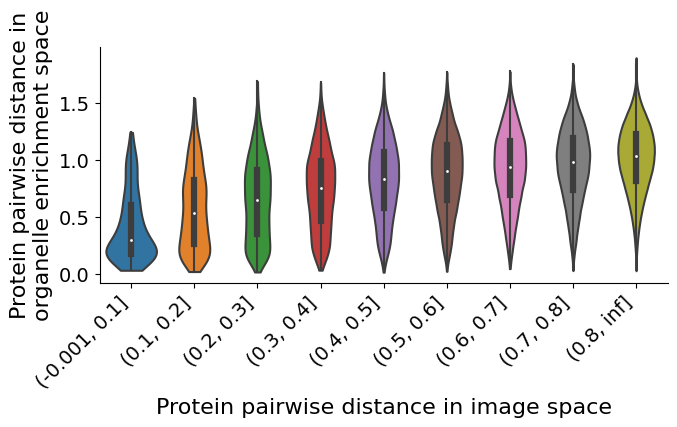

In [16]:
# define custom bin edges 
bin_edges = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, np.inf]  

# create bins for x
df['cytoself_bins'] = pd.cut(df['cytoself'], bins=bin_edges, include_lowest=True)

# set up the plot
plt.figure(figsize=(7, 4))

# create a violin plot using seaborn
sns.violinplot(x='cytoself_bins', y='OrgIP', data=df, inner='box', cut=0, density_norm="count",)

# labeleing the plot
plt.ylabel('Protein pairwise distance in\norganelle enrichment space', fontsize=16)
plt.xlabel('Protein pairwise distance in image space', fontsize=16)
plt.title('', fontsize=16)
plt.xticks(rotation=45, fontsize=14, ha = 'right')
plt.yticks(fontsize=14)
plt.tight_layout()

# remove grid
plt.grid(False)
# remove top and right spines from plot
sns.despine()

# save the plot
plt.savefig(os.path.join(output_dir, "protein_pairwise_PCA_dist_violinplot.pdf"), format="pdf", bbox_inches="tight", dpi=600)
plt.show()